# <i class="fas fa-star"></i>&hairsp;T01: Single Cell Analysis


```{hint}
By the end of this notebook, you will be able to:

- Load neuronal reconstructions from multiple sources (local files and demo datasets)
- Visualize neuronal morphology using PySNT's display function
- Extract basic quantitative measurements from neuronal trees using TreeStatistics and its variants
- Visualize quantitative measurements using color mappers
- Generate histograms of morphological features
- Apply statistical fitting to morphological distributions
- Transform neuronal reconstructions using geometric operations and modifications
- Work with SWC-type labels to identify and isolate different cellular compartments
- Work with subsets of reconstruction nodes (point clouds)

**Estimated Time**: 20-30 minutes

```

```{note}
Make sure to read these resources before running this notebook:
- [Install](../install.md) - Installation instructions
- [Quickstart](../quickstart.md) - Get started quickly
- [Overview](../overview.md) - Tour of pysnt's architecture
```

## Setup and Initialization

As always, we start by initializing pysnt. We'll also set some generic options suitable for notebook execution:

In [27]:
import pysnt
pysnt.set_option('java.logging.level', 'Error') # Set logging level to 'Error' to reduce console output (see Overview for details)
pysnt.set_option('display.chart_format', 'svg') # SVG plots and histograms
pysnt.set_option('display.chart_dpi', 150) # Rendering resolution

import pysnt
pysnt.initialize()

## Loading a Tree

As mentioned in the [Quickstart](../quickstart.md) guide, in SNT a neuronal reconstruction is a {class}`pysnt.Tree` object.

There are multiple ways to load a tree:
- From a local file
- From a remote database: Using loaders for major online databases: FlyCircuit, InsectBrain, NeuroMorpho, MouseLight 
- From a demo dataset

To load a local file we can use:

In [ ]:
## Loading from local file
from pysnt import Tree
try:
    tree = Tree('/path/to/a/swc/file.swc')
    tree = Tree('/path/to/a/swc/file.swc', "axon") # will only load axon-tagged nodes
except FileNotFoundError as e: # Handle Python-exceptions first
    print(f"File does not exist: {e}")
except Exception as e:  # Catch SNT exceptions
    print(f"Unexpected error: {e}")

Unexpected error: java.lang.IllegalArgumentException: File is not available: /path/to/a/swc/file.swc


(which of course will fail, since these files don't exist). 

We will access reconstruction files from remote databases in subsequent tutorials. 
For now, let's use some demo datasets. We'll use {class}`pysnt.SNTService`: SNT's SciJava service that provides convenience access to common operations as well as the running SNT instance: 

In [3]:
from pysnt import SNTService
snt_service = SNTService()
tree = snt_service.demoTree('pyramidal')  # or 'OP1' (DIADEM dataset), or 'DG' (Dentate gyrus granule cell), or 'fractal' for an L-system toy neuron
print(f"Demo tree loaded: {tree.getLabel()}")

Demo tree loaded: AA0001


Let's display it! We could use one of SNT's advanced viewers like [Reconstruction Viewer](https://imagej.net/plugins/snt/reconstruction-viewer) ({class}`pysnt.viewer.Viewer3D`) or [Reconstruction Plotter](https://imagej.net/plugins/snt/manual#reconstruction-plotter) ({class}`pysnt.viewer.Viewer2D`), but for now let's simply show the Tree's skeleton. We can use {func}`display() <pysnt.display.display>`: it is a convenient function that allows us to automagically display all sorts of objects: from text, to tables, to -- as we'll see in subsequent tutorials -- 3D scenes:

[SNTUtils] Retrieving org.scijava.Context...

[INFO] [SNT] 116 scijava services loaded


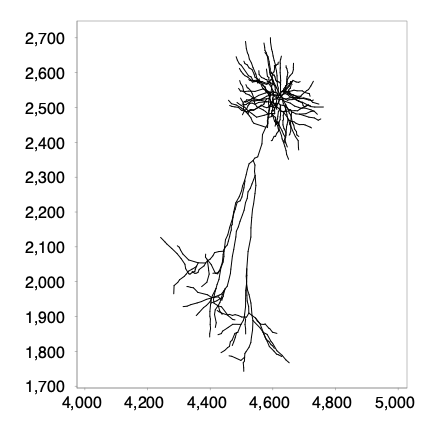

{'type': matplotlib.figure.Figure,
 'data': <Figure size 400x400 with 1 Axes>,
 'metadata': {'source_type': 'SNTChart',
  'format': 'svg',
  'scale': 1.0,
  'is_combined': False,
  'title': 'AA0001',
  'containsValidData': True,
  'isLegendVisible': True},
 'error': None}

In [4]:
pysnt.display(tree)

## Measuring a Tree

Most simply, a Tree can be measured using {class}`pysnt.analysis.TreeStatistics`. Further specialized measurements (Strahler, Sholl, graph analysis, persistence homology, etc.) are retrieved using other classes in {mod}`pysnt.analysis`. We will discuss those in subsequent tutorials. Here we'll focus on TreeStatistics. We construct an instance like so:

In [5]:
from pysnt.analysis import TreeStatistics
t_stats = TreeStatistics(tree)

TreeStatistics provides a variety of single value measurements as well as distribution statistics. Single value metrics:

In [6]:
cable = t_stats.getCableLength()
print("The cable length is %d micrometers" % cable)
n_bps = len(t_stats.getBranchPoints())
print(f"The no. of branch points is: {n_bps}")

The cable length is 13718 micrometers
The no. of branch points is: 82


```{tip}
You can use Python's `help` function to know more about a class or method, e.g.,: `help(TreeStatistics)`
```

To see the full list of [supported metrics](https://imagej.net/plugins/snt/metrics), we can use {doc}`getMetrics(choice) </pysnt/analysis/treestatistics_doc>`, where 'choice' is either 'safe' (metrics that do not require the Tree to validate as an acyclic rooted graph), 'common' (most frequently used), 'quick' (used by SNT's _Quick Measure..._ command), or 'all':

In [7]:
print("The following metrics are available:")
metrics = t_stats.getMetrics('all')
for i in range(0, len(metrics), 2):
    left = f"{i+1:3d}. {metrics[i]}" if i < len(metrics) else ""
    right = f"{i+2:3d}. {metrics[i+1]}" if i+1 < len(metrics) else ""
    print(f'{left:<60}{right}')

The following metrics are available:
  1. Longest shortest path: Extension angle                   2. Longest shortest path: Extension angle XY
  3. Longest shortest path: Extension angle XZ                4. Longest shortest path: Extension angle ZY
  5. Branch contraction                                       6. Branch fractal dimension
  7. Branch length                                            8. Branch mean radius
  9. Branch surface area                                     10. Branch volume
 11. Complexity index: ACI                                   12. Complexity index: DCI
 13. Convex hull: Boundary size                              14. Convex hull: Boxivity
 15. Convex hull: Centroid-root distance                     16. Convex hull: Elongation
 17. Convex hull: Roundness                                  18. Convex hull: Size
 19. Convex hull: Compactness                                20. Convex hull: Eccentricity
 21. Depth                                                 

These metrics can be used to retrieve computations, distributions, etc.

In [8]:
metric = "Internode distance" #fuzzy matching is supported so we can abbreviate distance
summary_stats = t_stats.getSummaryStats(metric)
print("The average inter-node distance is %d µm" % summary_stats.getMean())
print("The standard deviation is %d µm" % summary_stats.getStandardDeviation())

The average inter-node distance is 14 µm
The standard deviation is 6 µm


A neat feature of SNT, is that it is quick and convenient to inspect quantitative data. E.g., one can plot histograms directly:

```{note}
The following cell may produce verbose logging output from the underlying libraries during histogram generation. This output can be safely ignored.
```

[main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(1)[1.00 x Gaussian Distribution(14.3722, 6.6011)] = -2862.7968
[main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(2)[0.69 x Gaussian Distribution(13.5866, 5.9980) + 0.31 x Gaussian Distribution(16.1047, 7.4705)] = -2851.4582


{'type': matplotlib.figure.Figure,
 'data': <Figure size 700x350 with 2 Axes>,
 'metadata': {'source_type': 'SNTChart_List',
  'sntchart_count': 2,
  'displayed_count': 2,
  'panel_layout': 'auto',
  'title': None},
 'error': None}

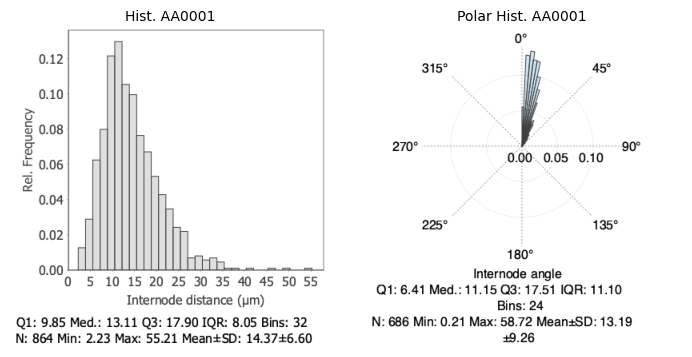

In [9]:
hist1 = t_stats.getHistogram('internode distance')
hist2 = t_stats.getPolarHistogram('internode angle')
pysnt.display([hist1, hist2])

Did you notice _GaussianMixture_ debug message in the background? It reflects background computations on the distribution. While SNT is not a statistical package, it does offer entry points for detailed data inspection. E.g., one can fit the histogram distribution to a Gaussian/ Gaussian mixture model directly:

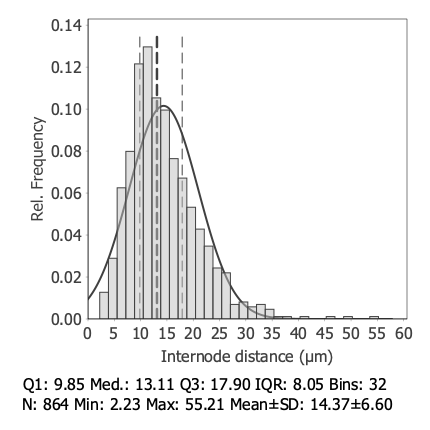

{'type': matplotlib.figure.Figure,
 'data': <Figure size 400x400 with 1 Axes>,
 'metadata': {'source_type': 'SNTChart',
  'format': 'svg',
  'scale': 1.0,
  'is_combined': False,
  'title': 'Hist. AA0001',
  'containsValidData': True,
  'isLegendVisible': False},
 'error': None}

In [10]:
hist1.setGaussianFitVisible(True) # or hist1.setGMMFitVisible(True) for Gaussian mixture model
hist1.setQuartilesVisible(True) # Display 1st quartile, Median, and 3rd quartile
pysnt.display(hist1)

We can actually 'overlay' the distribution on the reconstruction itself, by means of a `ColorMapper`. Color mappers map quantitative traits to reconstructions. Because we are handling Trees, we can use {class}`TreeColorMapper <pysnt.analysis.TreeColorMapper>`.

To visualize the nodes we need to use a viewer. We can use [Reconstruction Plotter](https://imagej.net/plugins/snt/manual#reconstruction-plotter) (i.e., {class}`pysnt.viewer.Viewer2D`). We will use 3D viewers in subsequent tutorials, but for now we'll use the 2D viewer because it is quite simple: 

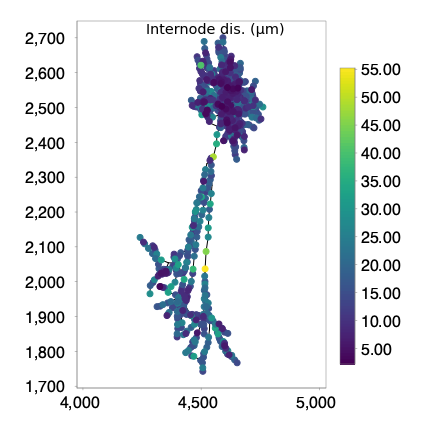

{'type': matplotlib.figure.Figure,
 'data': <Figure size 400x400 with 1 Axes>,
 'metadata': {'source_type': 'SNTChart',
  'format': 'svg',
  'scale': 1.0,
  'is_combined': False,
  'title': 'Reconstruction Plotter',
  'containsValidData': True,
  'isLegendVisible': True},
 'error': None}

In [ ]:
from pysnt.analysis import TreeColorMapper
from pysnt.viewer import Viewer2D

# assign colors
color_mapper = TreeColorMapper()
color_mapper.map(tree, 'internode distance', 'viridis') # tree, metric, LUT/colormap (NB: some LUTs are case-sensitive)

# assemble viewer
viewer = Viewer2D()
viewer.add(tree)
viewer.addColorBarLegend(color_mapper)

# remove mapping: restore original colors
color_mapper.unMap(tree)

pysnt.display(viewer, title='Internode Dist. (µm)')


## Cellular Compartments

If the reconstruction nodes are tagged with SWC-type flags, it is possible to retrieve the cellular compartments (axon, basal dendrites, etc).

Found 3 SWC type labels: [(basal) dendrite, apical dendrite, soma]
soma has only a single node. Skipping visualization


{'type': matplotlib.figure.Figure,
 'data': <Figure size 700x350 with 2 Axes>,
 'metadata': {'source_type': 'SNTChart_List',
  'sntchart_count': 2,
  'displayed_count': 2,
  'panel_layout': 'auto',
  'title': None},
 'error': None}

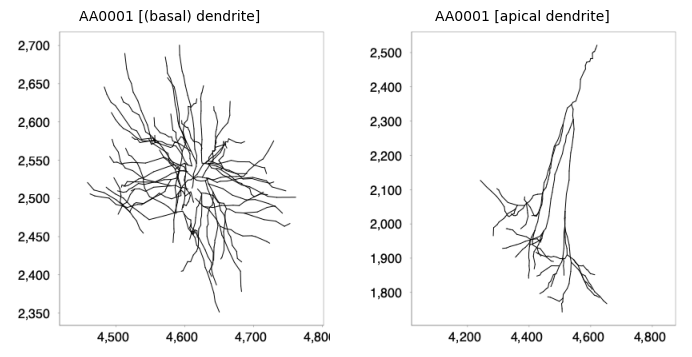

In [12]:
# Find out how many compartments exist
types = tree.getSWCTypeNames(True) # include soma?
print(f"Found {len(types)} SWC type labels: {types}")

# Retrieve each compartment (as subtree)
all_sub_trees = []
for type in types:
    sub_tree = tree.subTree(type)
    if (len(sub_tree.getNodes()) == 1):
        print(f"{type} has only a single node. Skipping visualization")
        continue
    all_sub_trees.append(sub_tree)

# Display subtrees
pysnt.display(all_sub_trees)


## Subsets of Nodes

Subsets of nodes can be studied using {class}`NodeStatistics <pysnt.analysis.NodeStatistics>`, a TreeStatistics variant that operates on collections of nodes, i.e., point clouds.

[main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(1)[1.00 x Gaussian Distribution(23.6177, 20.2284)] = -366.8408
[main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(2)[0.69 x Gaussian Distribution(19.2077, 15.0684) + 0.31 x Gaussian Distribution(33.3124, 25.6294)] = -362.6232


{'type': matplotlib.figure.Figure,
 'data': <Figure size 700x350 with 2 Axes>,
 'metadata': {'source_type': 'SNTChart_List',
  'sntchart_count': 2,
  'displayed_count': 2,
  'panel_layout': 'auto',
  'title': None},
 'error': None}

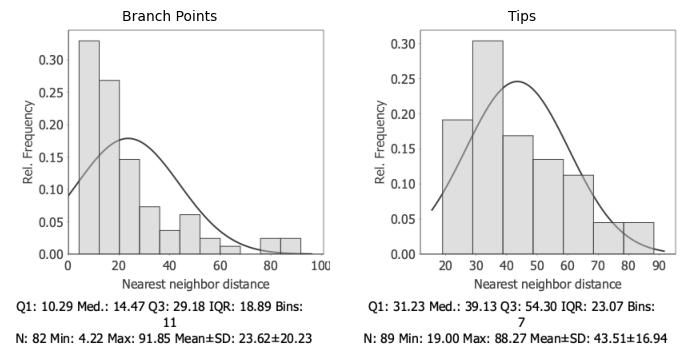

In [13]:
from pysnt.analysis import NodeStatistics

node_subsets = [tree.getBPs(), tree.getTips()] # list of branch points (BPs) and end points (tips)
histograms = []
for subset in node_subsets:
    node_stats = NodeStatistics(subset)
    hist = node_stats.getHistogram('nearest neighbor distance')
    hist.setGaussianFitVisible(True)
    histograms.append(hist)
    
# pysnt.set_option('display.chart_format', 'pdf')

pysnt.set_option('display.chart_format', 'svg')
pysnt.display(histograms, panel_titles=['Branch Points', 'Tips'])

The distribution of nearest-neighbor distances for branch points is strongly right-skewed, indicating that many branch points are tightly packed together within 30µm. The long tail extending toward larger distances (up to about 90µm) shows a few isolated points that are much farther apart.

The tips have a broader and more symmetric distribution compared to the branch points: Tips are spaced farther apart on average and more evenly distributed in space than branch points.

We can visualize the nodes by assembling a simple 2D scene:

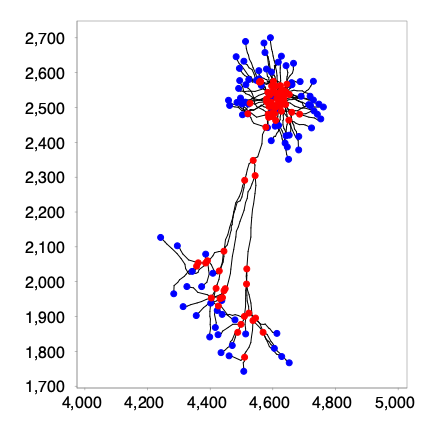

{'type': matplotlib.figure.Figure,
 'data': <Figure size 400x400 with 1 Axes>,
 'metadata': {'source_type': 'SNTChart',
  'format': 'svg',
  'scale': 1.0,
  'is_combined': False,
  'title': 'Reconstruction Plotter',
  'containsValidData': True,
  'isLegendVisible': True},
 'error': None}

In [14]:
viewer = Viewer2D()
viewer.add(tree)
viewer.addNodes(tree.getBPs(), 'red', 'branch points')
viewer.addNodes(tree.getTips(), 'blue', 'tips')
pysnt.display(viewer)

Which illustrates our previous assessment. To find out _which_ branch points are much farther apart, we can map the distances into the structure. Because we used `NodeStatistics`, we now use {class}`NodeColorMapper <pysnt.analysis.NodeColorMapper>` as color mapper:

{'type': matplotlib.figure.Figure,
 'data': <Figure size 700x350 with 2 Axes>,
 'metadata': {'source_type': 'Viewer2D_List',
  'viewer2d_count': 2,
  'displayed_count': 2,
  'panel_layout': 'auto',
  'title': 'NN Dist. (µm)'},
 'error': None}

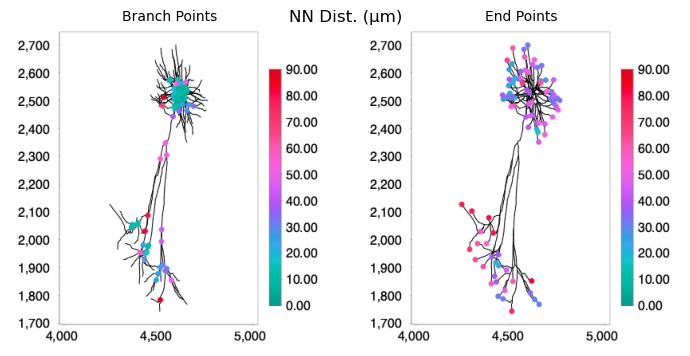

In [15]:
from pysnt.analysis import NodeColorMapper

node_subsets = [tree.getBPs(), tree.getTips()]
viewers = []
for subset in node_subsets:
    node_stats = NodeStatistics(subset)
    node_mapper = NodeColorMapper(node_stats)
    node_mapper.setMinMax(0, 90) # set the same boundaries for both mappers (in µm)
    node_mapper.map("nearest neighbor distance", "ice") # mapping metric, lut/colormap LUT/colormap (NB: some LUTs are case-sensitive)
    
    # Assemble a 2D scene as before
    viewer = Viewer2D()
    viewer.add(tree)
    viewer.addNodes(node_mapper.getNodesByColor())
    viewer.addColorBarLegend(node_mapper)
    viewers.append(viewer)

pysnt.display(viewers, title="NN Dist. (µm)", panel_titles=["Branch Points", "End Points"])

## Transforming Trees

You should be able to use auto-completion on your IDE to explore some of the transformation options available. Transformations occur in place, so we'll work on a copy of the initial tree. Here are some examples.

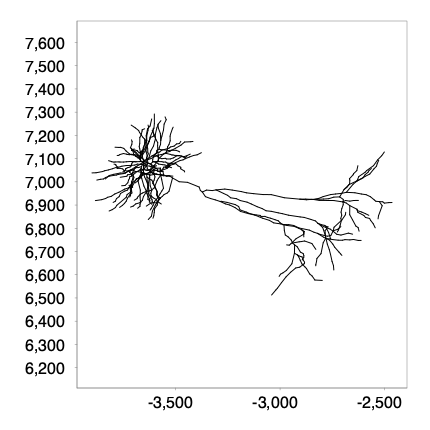

{'type': matplotlib.figure.Figure,
 'data': <Figure size 400x400 with 1 Axes>,
 'metadata': {'source_type': 'SNTChart',
  'format': 'svg',
  'scale': 1.0,
  'is_combined': False,
  'title': 'AA0001',
  'containsValidData': True,
  'isLegendVisible': True},
 'error': None}

In [16]:
tree_transformed = tree.clone() # Duplicate Tree
tree_transformed.rotate(Tree.Z_AXIS, 90) # Rotate around Z axis by 90 degrees
tree_transformed.translate(100, 100, 100) # Translate by 100, 100, 100 µm in X,Y,Z
tree_transformed.scale(1.5, 1.5, 3.0) # Scale by 1.50 in XY; 3.0 in Z
pysnt.display(tree_transformed)

There are also `transform()` and `transformedCopy()` {class}`methods <pysnt.Tree>` that allow for standardized transformations using space-separated flags:

Projection flags:
- `zy`: ZY projection
- `xz`: XZ projection

Translation flags:
- `zero-origin`: Tree is translated so that its root has (0,0,0) coordinates

Rotation flags:
- `upright-geodesic`: Tree is rotated to vertically align its "longest shortest path" (in graph theory this is called the longest geodesic, or graph diameter). Sometimes it is also called the neuron's _backbone_ or _spine_
- `upright-tips`: Tree is rotated to vertically align its [root, tips centroid] vector
- `r#`: With # specifying a positive integer (e.g., r90): Tree is rotated by the specified angle (in degrees)

Example:

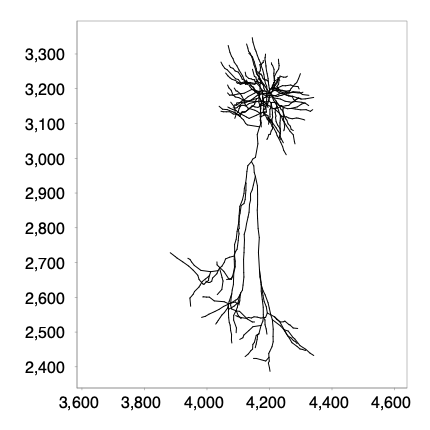

{'type': matplotlib.figure.Figure,
 'data': <Figure size 400x400 with 1 Axes>,
 'metadata': {'source_type': 'SNTChart',
  'format': 'svg',
  'scale': 1.0,
  'is_combined': False,
  'title': 'AA0001',
  'containsValidData': True,
  'isLegendVisible': True},
 'error': None}

In [17]:
tree_transformed = tree
tree_transformed = tree.transformedCopy("upright-geodesic") # Project into xz plane + rotate vertically until the longest path in the tree graph is vertical
pysnt.display(tree_transformed)

## Measuring a Group of Trees

Multiple trees are analyzed using {class}`pysnt.analysis.MultiTreeStatistics`, a TreeStatistics variant that analyses trees belonging to a common group. Its usage is rather similar to TreeStatistics. 

We start by importing a group of Trees. As usual we could use local files, e.g., using:

- `Tree.listFromDir('/path/to/a/directory/')` to load all reconstruction files in the directory
- `Tree.listFromDir('/path/to/a/directory/', 'pattern')` to load all reconstruction files in the directory with `pattern` in their filename
- `Tree.listFromDir('/path/to/a/directory/', 'pattern', 'swc_type_label')` to load all reconstruction files in the directory with `pattern` in their filename, with `swc_type_label` identifying the compartments to be imported 'soma', 'axon', 'dendrite', 'all', etc.


As before, we'll use a small demo dataset for now, from which we can instantiate a `MultiTreeStatistics` instance:

In [18]:
from pysnt.analysis import MultiTreeStatistics
trees = snt_service.demoTrees() # dendrites from 4 pyramidal cells from the MouseLight database
m_stats = MultiTreeStatistics(trees)
m_stats.setLabel("multiple trees analysis") # Optional: we can set a unifying label to be used in reports, etc.

Subsequent analysis works the same as with `TreeStatistics`:

[main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(1)[1.00 x Gaussian Distribution(4893.6491, 227.9298)] = -30816.9576
[main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(2)[0.42 x Gaussian Distribution(4811.8170, 236.9718) + 0.58 x Gaussian Distribution(4952.9253, 201.3027)] = -30775.8996


{'type': matplotlib.figure.Figure,
 'data': <Figure size 700x350 with 2 Axes>,
 'metadata': {'source_type': 'SNTChart_List',
  'sntchart_count': 2,
  'displayed_count': 2,
  'panel_layout': 'auto',
  'title': None},
 'error': None}

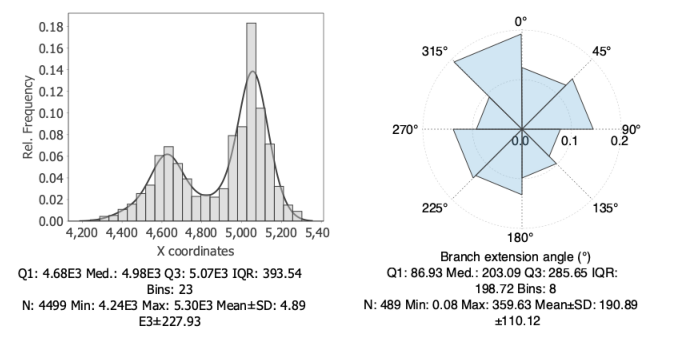

In [19]:
hist1 = m_stats.getHistogram("x coordinates")
hist1.setGMMFitVisible(True)
hist2 = m_stats.getPolarHistogram("branch extension angle")
pysnt.display([hist1, hist2], show_panel_titles=False)

To display the group, we can use [Reconstruction Plotter](https://imagej.net/plugins/snt/manual#reconstruction-plotter) (i.e., {class}`Viewer2D <pysnt.viewer.Viewer2D>`) (we will use 3D viewers in the subsequent tutorials, but for now we'll use the 2D viewer because it is quite simple): 

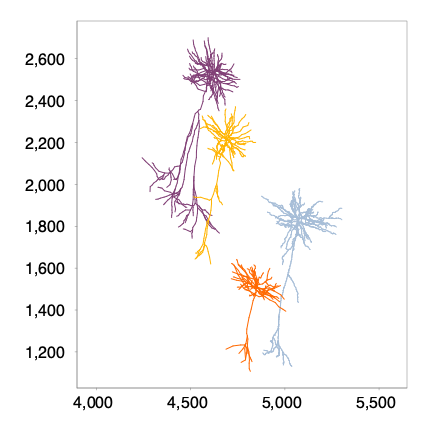

{'type': matplotlib.figure.Figure,
 'data': <Figure size 400x400 with 1 Axes>,
 'metadata': {'source_type': 'SNTChart',
  'format': 'svg',
  'scale': 1.0,
  'is_combined': False,
  'title': 'Reconstruction Plotter',
  'containsValidData': True,
  'isLegendVisible': True},
 'error': None}

In [20]:
from pysnt.viewer import Viewer2D
viewer = Viewer2D()
viewer.add(trees)
pysnt.display(viewer)

Using what we learned so far, we can display the cells in a more concise way:

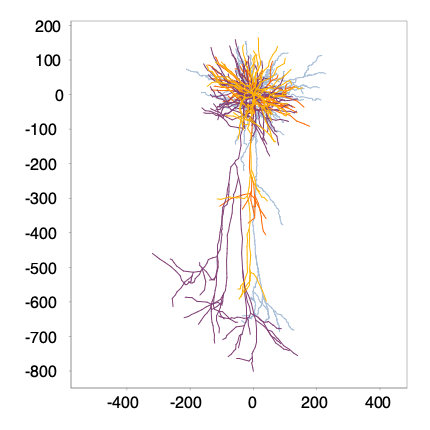

{'type': matplotlib.figure.Figure,
 'data': <Figure size 400x400 with 1 Axes>,
 'metadata': {'source_type': 'SNTChart',
  'format': 'svg',
  'scale': 1.0,
  'is_combined': False,
  'title': 'Reconstruction Plotter',
  'containsValidData': True,
  'isLegendVisible': True},
 'error': None}

In [21]:
trees_transformed = Tree.transform(trees, "zero-origin upright-geodesic", False) # Move all roots to (0,0,0) coordinate, rotate the cells so their main axis is vertical
viewer = Viewer2D()
viewer.add(trees_transformed)
pysnt.display(viewer)

## Measuring Groups of Trees

Instead of [MultipleTreeStatistics](#measuring-a-group-of-trees), we now use {class}`GroupedTreeStatistics <pysnt.analysis.GroupedTreeStatistics>`: The approach is similar to what we've been doing so far, with a minor difference: We will first initialize the class, then we'll add our cell groups.

To define the cell groups, we'll just split the cells we've been studying evenly into two sub-groups:

In [22]:
from pysnt.analysis import GroupedTreeStatistics
g_stats = GroupedTreeStatistics()

trees = snt_service.demoTrees() # retrieve demo trees
mid = len(trees) // 2 # group mid point
g_stats.addGroup(trees[:mid], "group 1") # assign first half to group 1
g_stats.addGroup(trees[mid:], "group 2") # assign second half to group 2

def get_histogram(metric):
    hist = g_stats.getHistogram(metric)
    hist.setGaussianFitVisible(True) 
    hist.setQuartilesVisible(True)
    return hist

hist1 = get_histogram("x coordinates")
hist2 = get_histogram("internode angle")

[main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(1)[1.00 x Gaussian Distribution(4602.7220, 101.9468)] = -8981.2370
[main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(2)[0.43 x Gaussian Distribution(4574.4973, 107.9735) + 0.57 x Gaussian Distribution(4623.9380, 91.5477)] = -8972.1973
[main] INFO smile.stat.distribution.GaussianMixture - The BIC of Mixture(3)[0.21 x Gaussian Distribution(4527.5178, 110.7982) + 0.39 x Gaussian Distribution(4597.4964, 93.5217) + 0.40 x Gaussian Distribution(4646.1892, 78.7857)] = -8956.2239


Because we are working with group statistics, there are new functions to compare groups, including T-testing and ANOVA-testing. There are also some new plotting options:

{'type': matplotlib.figure.Figure,
 'data': <Figure size 700x700 with 4 Axes>,
 'metadata': {'source_type': 'SNTChart_List',
  'sntchart_count': 4,
  'displayed_count': 4,
  'panel_layout': 'auto',
  'title': None},
 'error': None}

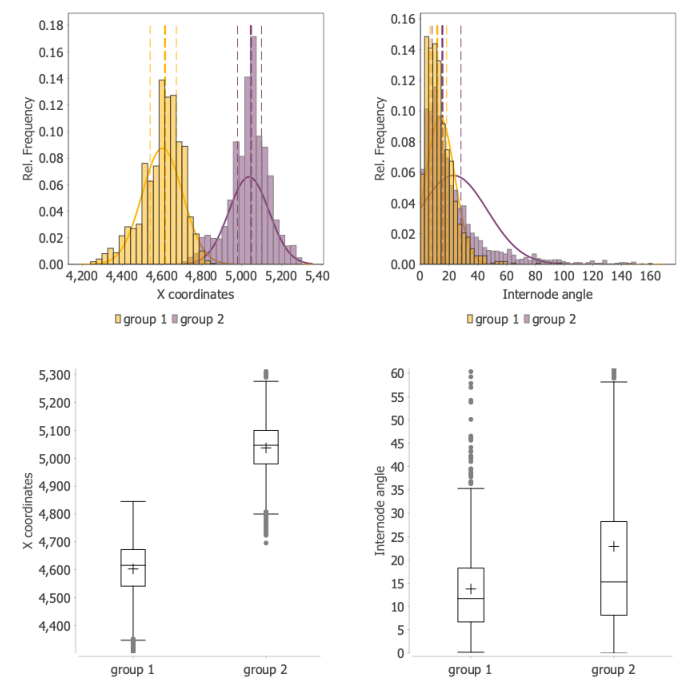

In [23]:
plot1 = g_stats.getBoxPlot("x coordinates")
plot2 = g_stats.getBoxPlot("internode angle")
pysnt.display([hist1, hist2, plot1, plot2], show_panel_titles=False)

Internally, each group is assigned a `MultiTreeStatistics` instance, so we can use the same methods as before, and study each [individual group](#measuring-a-group-of-trees):

In [24]:

for group in g_stats.getGroups():
    m_stats = g_stats.getGroupStats(group) # Retrieve the MultiTreeStatistics instance assigned to group
    print(f'Total no. of branch points in {group}: {len(m_stats.getBranches())}')

Total no. of branch points in group 1: 258
Total no. of branch points in group 2: 231


Actually, we can retrieve metrics in bulk like one would do from SNT's [Measurements prompt](https://imagej.net/plugins/snt/analysis#measurements). We can exploit the fact that (Multi)TreeStatistics keeps an internal table of measurements. Thus, the strategy is as follows:

1. Define a master table to hold the data
2. Define a list of metrics
3. For each group, dump measurements into the master table

Let's implement it:

Column 'SWC Type(s)' is all NaN, skipping normalization
Column 'No. of branch points [N]' has no variation (min=max=2), setting to 0.5
Column 'No. of fitted paths [MIN]' has no variation (min=max=0.0), setting to 0.5
Column 'No. of fitted paths [MAX]' has no variation (min=max=0.0), setting to 0.5
Column 'No. of fitted paths [MEAN]' has no variation (min=max=0.0), setting to 0.5
Column 'No. of fitted paths [STD_DEV]' has no variation (min=max=0.0), setting to 0.5
Column 'No. of fitted paths [N]' has no variation (min=max=2), setting to 0.5
Column 'No. of nodes [N]' has no variation (min=max=2), setting to 0.5
Column 'No. of paths [N]' has no variation (min=max=2), setting to 0.5
Column 'No. of spines/varicosities [MIN]' has no variation (min=max=0.0), setting to 0.5
Column 'No. of spines/varicosities [MAX]' has no variation (min=max=0.0), setting to 0.5
Column 'No. of spines/varicosities [MEAN]' has no variation (min=max=0.0), setting to 0.5
Column 'No. of spines/varicosities [STD_DEV]

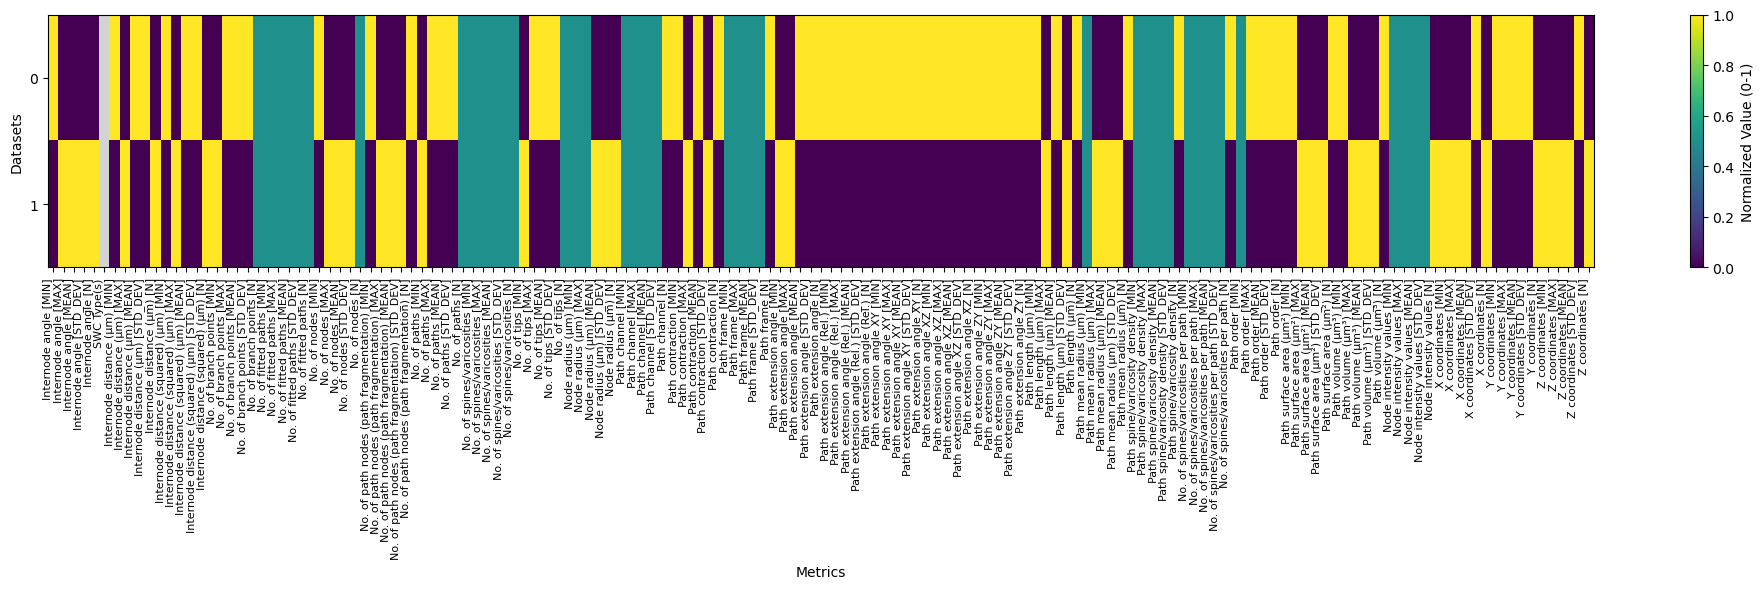

{'type': xarray.core.dataset.Dataset,
 'data': <xarray.Dataset> Size: 2kB
 Dimensions:                                           (index: 2)
 Coordinates:
   * index                                             (index) int64 16B 0 1
 Data variables: (12/151)
     Internode angle [MIN]                             (index) float64 16B 0.2...
     Internode angle [MAX]                             (index) float64 16B 97....
     Internode angle [MEAN]                            (index) float64 16B 13....
     Internode angle [STD_DEV]                         (index) float64 16B 10....
     Internode angle [N]                               (index) int64 16B 1071 ...
     SWC Type(s)                                       (index) object 16B  
     ...                                                ...
     Y coordinates [N]                                 (index) int64 16B 1485 ...
     Z coordinates [MIN]                               (index) float64 16B 2.4...
     Z coordinates [MAX]         

In [25]:
from pysnt.analysis import SNTTable
master_table = SNTTable()

for group in g_stats.getGroups():
    m_stats = g_stats.getGroupStats(group)
    m_stats.setTable(master_table)
    metrics = m_stats.getMetrics('safe')
    m_stats.measure(group, metrics, False) # group description, list of metrics, whether measurements should consider SWC compartment (axon/dendrites)

pysnt.set_option('display.table_mode', 'heatmap_norm')
pysnt.display(master_table, figsize=(20, 6), title=None)

```{tip}
For interactive data exploration (sorting, filtering, plotting), use:

:::{code-block} python
pysnt.set_option('display.table_mode', 'pandasgui')
pysnt.display(master_table)
:::

For converting the data into a Dataset shareable with numpy, seaborn, pandas, etc., use:

:::{code-block} python
dataset = pysnt.to_python(master_table)
:::
```

To display the groups, we can use the same strategy as before:

{'type': matplotlib.figure.Figure,
 'data': <Figure size 700x350 with 2 Axes>,
 'metadata': {'source_type': 'Viewer2D_List',
  'viewer2d_count': 2,
  'displayed_count': 2,
  'panel_layout': 'auto',
  'title': None},
 'error': None}

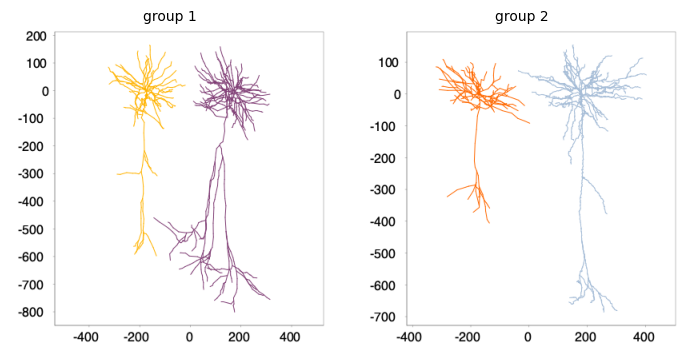

In [26]:
viewers = [] # visualization result: 1 viewer per group

for group in g_stats.getGroups():

    # Retrieve the trees in the group
    group_stats = g_stats.getGroupStats(group)
    group_trees = group_stats.getGroup() 

    # Define a viewer for the group
    viewer = Viewer2D()
    
    # Normalize absolute coordinates and rotate cells so their main axis is vertical
    group_trees_transformed = Tree.transform(group_trees, "zero-origin upright-geodesic", False)
    
    # Assign the group color and offset each tree by 350µm left/right
    # for better visualization
    n_trees = len(group_trees_transformed)
    for i, transformed_tree in enumerate(group_trees_transformed):
        # Calculate offset: negative for first half, positive for second half
        offset = (i - (n_trees - 1) / 2) * 350
        transformed_tree.translate(offset, 0, 0)
    
    # Add transformed trees to viewer and store result
    viewer.add(group_trees_transformed)
    viewer.setTitle(group)
    viewers.append(viewer)

pysnt.display(viewers, show_panel_titles=True)

## Summary and Next Steps

That concludes this tutorial. Have a look at remaining [tutorials](index.md) for further examples.


## Data Sources and References

Data used in this notebook is part of SNT's demo datasets. In particular, Dendrites of cells [AA001](https://doi.org/10.25378/janelia.5520037), [AA002](https://doi.org/10.25378/janelia.5520049), [AA0003](https://doi.org/10.25378/janelia.5520055), and [AA0004](https://doi.org/10.25378/janelia.5520205) of the [MouseLight database](https://ml-neuronbrowser.janelia.org/), under a Creative Commons Attribution 4.0 International License ([CC BY 4.0](https://creativecommons.org/licenses/by/4.0/)).

See [SNT citation](https://imagej.net/plugins/snt/faq#how-do-i-cite-snt) for details on how to properly cite SNT.